# Traffic sign recognition - Nerual Net

In [21]:
import numpy as np
np.random.seed(123)  # for reproducibility

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from qkeras import *

from sklearn import model_selection

from matplotlib import pyplot as plt
from imageio import imread # Need 'Imageio' 'Pillow' packages
import cv2

from math import floor, ceil
import os

import h5py

## Load data from German traffic sign database

In [2]:
main_folder_path = "./German traffic sign dataset"

csv_content = [] # One numpy array per folder
                 # Each numpy array x: image y: proprierties

# Iterate over all subfolders to read the CSV file of each class
for i in range(43):
    train_dataset_path = main_folder_path + "/GTSRB_Training" + '/' + "{:05.0f}".format(i) + '/'
    f_name = train_dataset_path + "GT-" + "{:05.0f}".format(i) + ".csv"
    csv_content.append(np.genfromtxt(f_name, delimiter=';', skip_header=1, dtype=str))
print(csv_content[0][1,:])

['00000_00001.ppm' '30' '30' '5' '5' '25' '25' '0']


In [3]:
# Load the images and respective class

image = []
img_num = 0
labels = np.empty(0)

for i in range(43):
    image_class = []
    train_dataset_path = main_folder_path + "/GTSRB_Training" + '/' + "{:05.0f}".format(i) + '/'
    for label_name in enumerate(csv_content[i][:,0]):
        image_class.append(imread(train_dataset_path + label_name[1])[:,:,0]) # Adding image
        labels = np.append(labels, i) # Appending image class based on folder
        img_num += 1
    image.append(image_class)

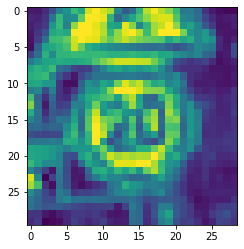

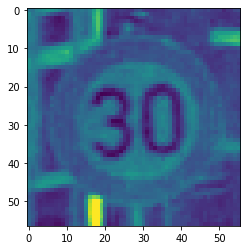

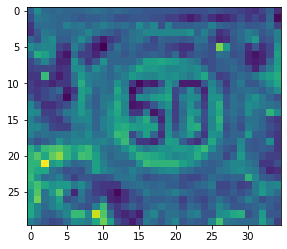

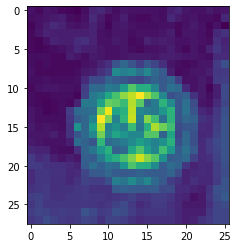

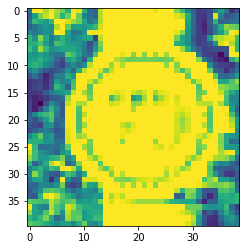

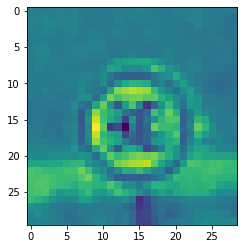

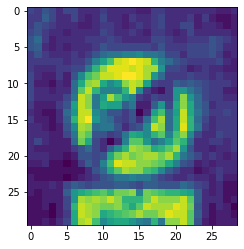

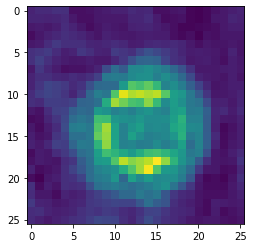

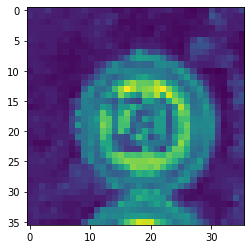

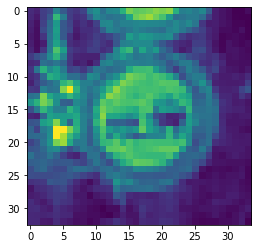

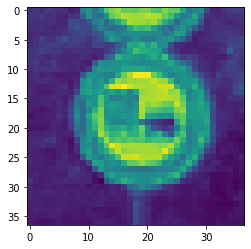

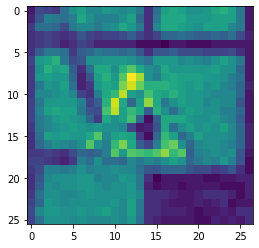

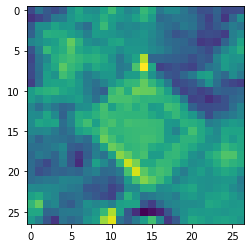

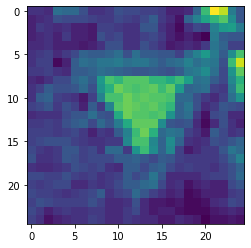

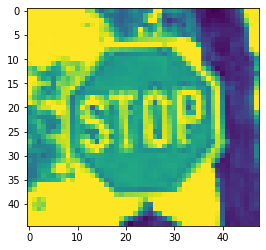

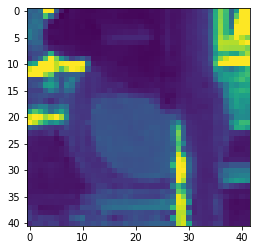

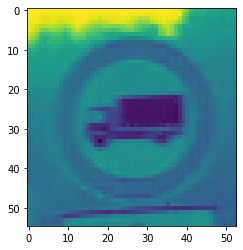

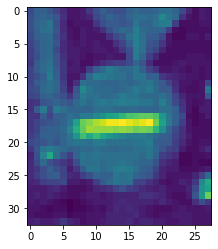

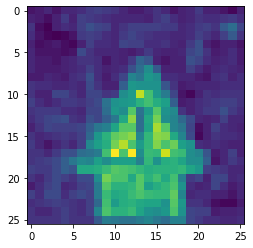

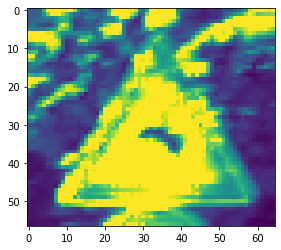

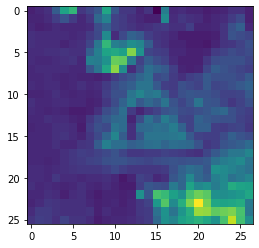

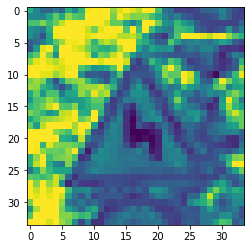

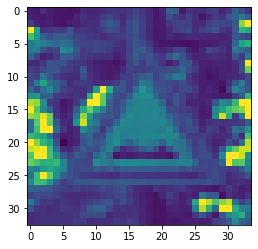

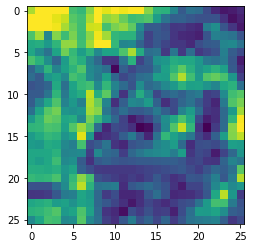

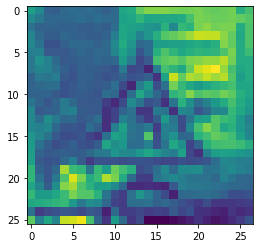

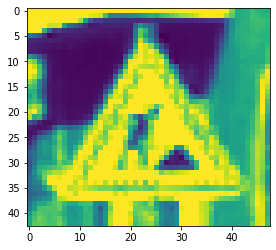

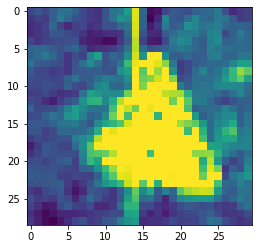

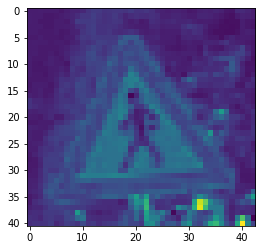

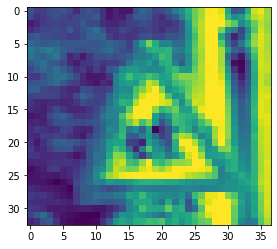

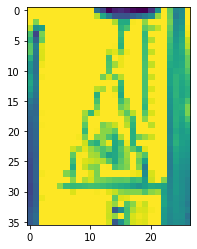

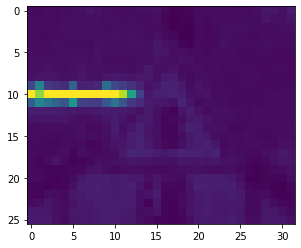

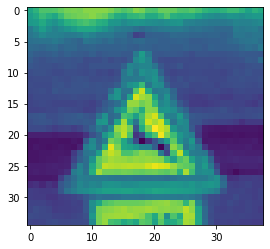

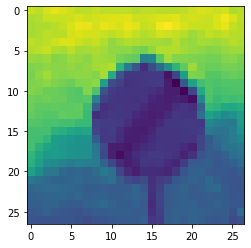

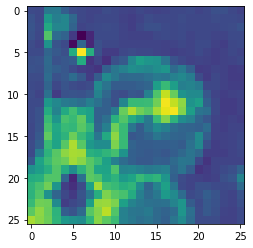

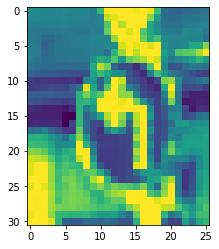

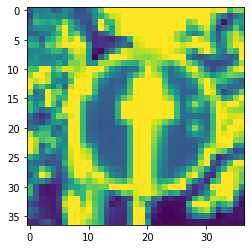

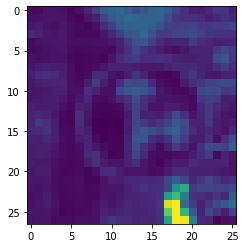

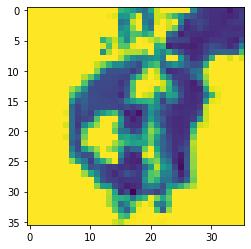

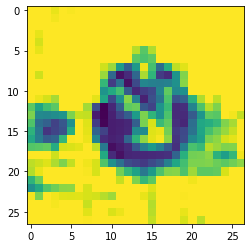

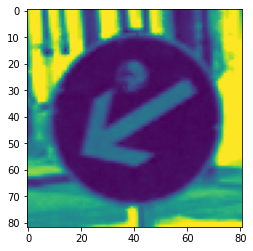

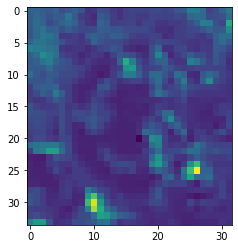

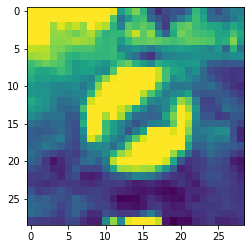

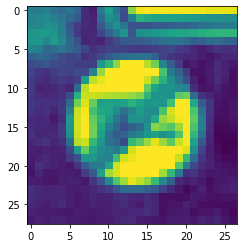

In [4]:
# Print the first image in every class
for i in image:
    plt.imshow(i[0])
    plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

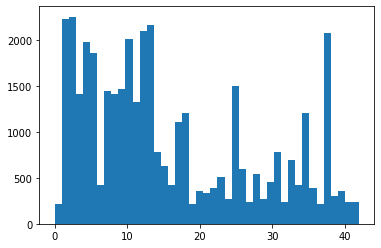

In [5]:
# Histogram of class population
plt.hist(labels, len(image))
plt.show

## Adapting the images

In [6]:
# Reshape training set
x_size = 32
y_size = 32
img_train = np.empty((img_num, x_size, y_size))

elaborated = 0

for image_set in enumerate(image):
    for image_array in enumerate(image_set[1]):
        # Cutting the image to match the content
        x2 = int(csv_content[image_set[0]][image_array[0], 5]) 
        x1 = int(csv_content[image_set[0]][image_array[0], 3])
        y2 = int(csv_content[image_set[0]][image_array[0], 6]) 
        y1 = int(csv_content[image_set[0]][image_array[0], 4])
        size = max(x2-x1, y2-y1)
        # Padding to have square images
        padded = np.pad(np.asarray(image_array[1][x1:x2, y1:y2]), \
                        ((floor((size-x2+x1)/2), ceil((size-x2+x1)/2)),\
                         (floor((size-y2+y1)/2), ceil((size-y2+y1)/2))))
        # Reshaping the image to match the selected dimension
        reshaped = cv2.resize(padded, (x_size, y_size), interpolation = cv2.INTER_AREA)
        # Copying the image inside the output array
        np.copyto(img_train[elaborated,:,:], reshaped)
        # Showing result
        #plt.imshow(img_train[elaborated,:,:])
        #plt.show()
        #Images should be one after another to train the model
        elaborated += 1

In [7]:
# Reshaping the train data to have a correct fit input
print(img_train.shape)
img_train_rsh = np.reshape(img_train, (img_train.shape[0], img_train.shape[1], img_train.shape[2],1))
print(img_train_rsh.shape)

(39209, 32, 32)
(39209, 32, 32, 1)


In [8]:
# Split train and validation data from the train dataset
x_train, x_test, y_train, y_test = model_selection.train_test_split(img_train_rsh, labels, test_size=0.25)
print(x_train.shape[0], x_test.shape[0], y_train.shape[0], y_test.shape[0])

29406 9803 29406 9803


In [9]:
# Prepare ground truth for classification
print(y_train.shape)
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = to_categorical(y_train, len(image))
Y_test = to_categorical(y_test, len(image))
print(Y_train.shape)

(29406,)
(29406, 43)


## Convolutional network model

In [37]:
x = x_in = Input((x_size, y_size, 1))
x = QConv2D(200, (7, 7), strides=(1,1), kernel_quantizer="stochastic_ternary", bias_quantizer="ternary", name="first_conv2d")(x)
x = QActivation("quantized_relu(3)")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = QConv2D(200, (4,4), strides=(1,1), kernel_quantizer="stochastic_ternary", bias_quantizer="ternary")(x)
x = QActivation("quantized_relu(3)")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = QConv2D(200, (4,4), strides=(1,1), kernel_quantizer="stochastic_ternary", bias_quantizer="ternary")(x)
x = QActivation("quantized_relu(3)")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = QDense(400)(x)
x = QActivation("quantized_relu(3)")(x)
x = QDense(43)(x)
x = Activation("softmax")(x)

In [39]:
model = Model(inputs=[x_in], outputs=[x])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, Y_train, batch_size=50, epochs=5, verbose=1)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
first_conv2d (QConv2D)       (None, 26, 26, 200)       10000     
_________________________________________________________________
q_activation_24 (QActivation (None, 26, 26, 200)       0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 200)       0         
_________________________________________________________________
q_conv2d_8 (QConv2D)         (None, 10, 10, 200)       640200    
_________________________________________________________________
q_activation_25 (QActivation (None, 10, 10, 200)       0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 200)         0   

## Testing the model

In [41]:
test_loss, test_acc = model.evaluate(x_test, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

307/307 - 38s - loss: 0.2402 - accuracy: 0.9257

Test accuracy: 0.9257370233535767


## Saving model

In [42]:
model.save("model_quantized.h5")
print("Saved model to disk")

Saved model to disk


## Prepare test data

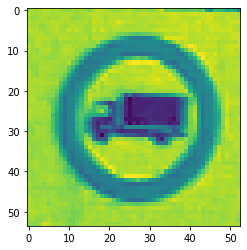

In [13]:
main_folder_path = "./German traffic sign dataset"
test_dataset_path = main_folder_path + "/GTSRB_Testing" + "/GT-final_test.test.csv"

test_csv = (np.genfromtxt(test_dataset_path, delimiter=';', skip_header=1, dtype=str))

image_test = []

for name_img in test_csv:
    image_test.append(imread("./German traffic sign dataset" + "/GTSRB_Testing" + "/" + name_img[0])[:,:,0])
    
plt.imshow(image_test[0])
plt.show()     

# Count total number of images:
img_test_num = len(image_test)
                                 
# Reshape test set
img_test = np.empty((img_num, x_size, y_size))

elaborated = 0

for image_set in enumerate(image_test):
    # Cutting the image to match the content
    x2 = int(test_csv[image_set[0], 5]) 
    x1 = int(test_csv[image_set[0], 3])
    y2 = int(test_csv[image_set[0], 6]) 
    y1 = int(test_csv[image_set[0], 4])
    size = max(x2-x1, y2-y1)
    # Padding to have square images
    padded = np.pad(np.asarray(image_set[1][x1:x2, y1:y2]), \
                    ((floor((size-x2+x1)/2), ceil((size-x2+x1)/2)),\
                     (floor((size-y2+y1)/2), ceil((size-y2+y1)/2))))
    # Reshaping the image to match the selected dimension
    reshaped = cv2.resize(padded, (x_size, y_size), interpolation = cv2.INTER_AREA)
    # Copying the image inside the output array
    np.copyto(img_test[elaborated,:,:], reshaped)
    # Showing result
    #plt.imshow(img_train[elaborated,:,:])
    #plt.show()
    #Images should be one after another to train the model
    elaborated += 1


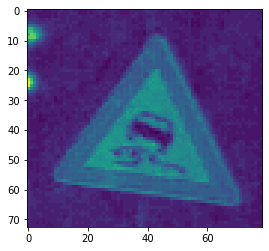

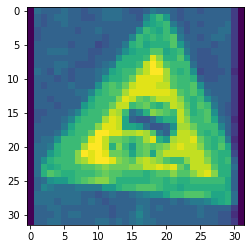

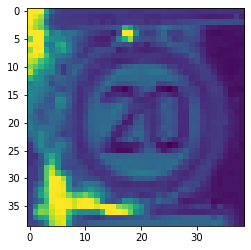

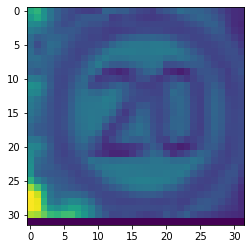

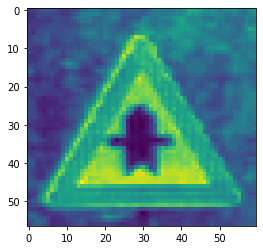

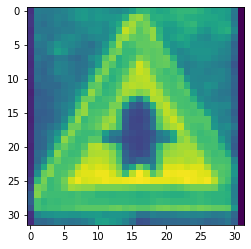

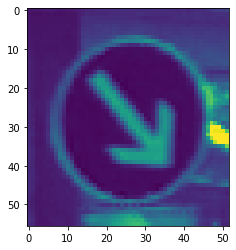

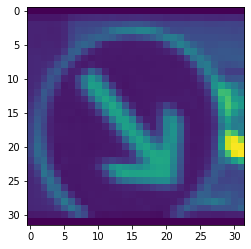

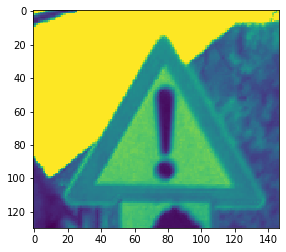

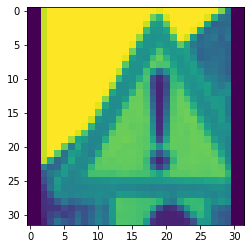

In [14]:
for i in [12, 243, 4, 5, 6]:
    plt.imshow(image_test[i])
    plt.show()  

    plt.imshow(img_test[i])
    plt.show()  